--------------------------------------------------------------------------------------------------------------------------
# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as stats
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')


### Outliers Function

In [2]:
def out_remove(col_name,df,cond,m):
    quartile1 = df[col_name].quantile(0.25)
    quartile3 = df[col_name].quantile(0.75)
    iqr = quartile3 - quartile1
    upper = quartile3 + m * iqr
    lower = quartile1 - m * iqr
    if(cond=='both'):
        new_df = df[(df[col_name] < upper) & (df[col_name] > lower)]
    elif(cond=='lower'):
        new_df = df[(df[col_name] > lower)]
    else:
        new_df = df[(df[col_name] < upper)]
    return new_df

------
# Reading and Checking data

In [3]:
diabetes_df = pd.read_csv("diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
diabetes_df.shape

(768, 9)

In [5]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


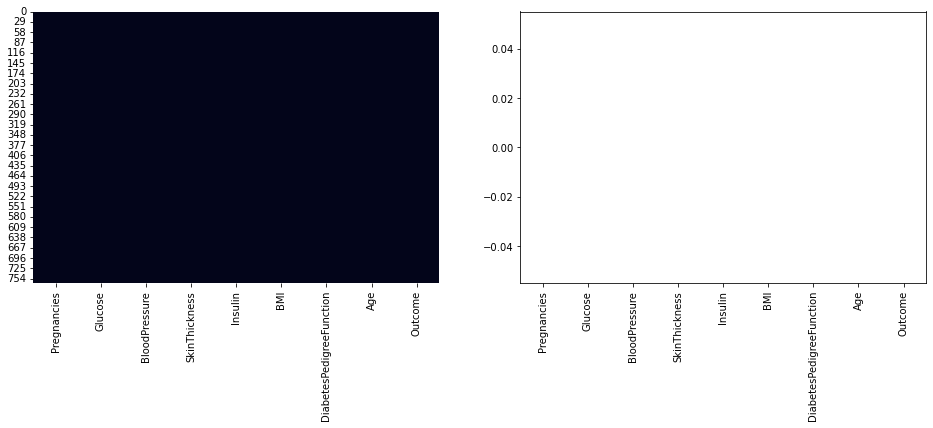

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(diabetes_df.isnull(), cbar=False, ax=ax1)
percent_missing = diabetes_df.isnull().mean() * 100
sns.barplot(x=percent_missing.index, y=percent_missing ,ax=ax2)
plt.xticks(rotation=90)
plt.show()

- **No null values** present in the data!
**there is no need to preprocess for missing values.**

Text(0.5, 1.0, 'Distribution of Outcome')

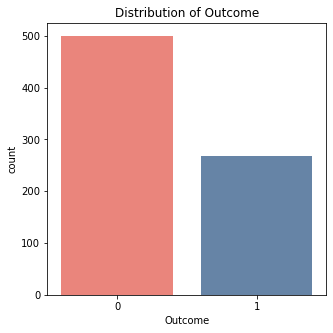

In [7]:
num_cols=diabetes_df.columns
rcParams['figure.figsize'] =5,5

sns.countplot(diabetes_df['Outcome'],palette=["#FC766AFF","#5B84B1FF"]).set_title('Distribution of Outcome')

- The dataset is **unbalanced**
- Due to this, predictions will be biased towards **Non-Diabetes** cases.
- so, we have to **balance** this class

In [8]:
diabetes_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


**Among the features, there are many features whose min() value is 0. Let's check out more of these features.**

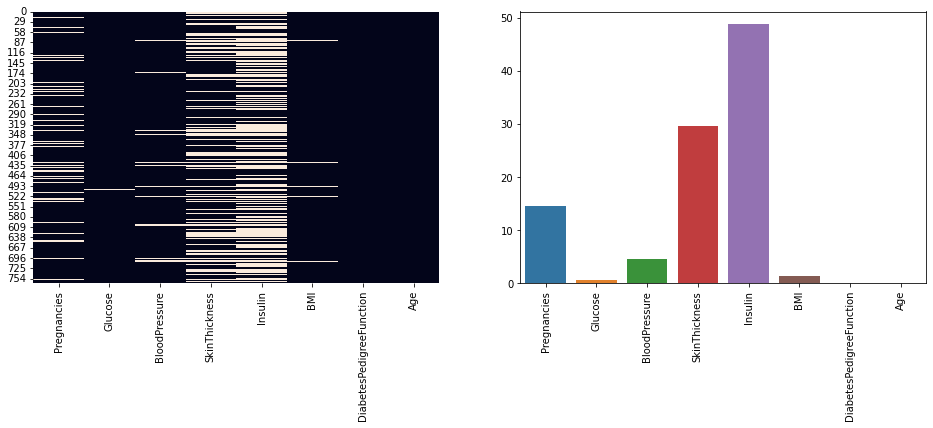

In [9]:
#Replace zeros with nan
d_copy = diabetes_df.copy()
d_copy=d_copy.drop(columns=['Outcome'],axis=1)
d_copy = d_copy.replace(0,np.nan)
#sns.heatmap(d_copy.isnull(),cmap = 'magma',cbar = False);

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(d_copy.isnull(), cbar=False, ax=ax1)
percent_missing = d_copy.isnull().mean() * 100
sns.barplot(x=percent_missing.index, y=percent_missing ,ax=ax2)
plt.xticks(rotation=90)
plt.show()

- Insulin ------ <span style="color:red"> 50%  </span> nan values. so we may remove insulin column. 
- Age and DiabetesPedigreeFunction ------ <span style="color:blue"> NO </span>nan values.


### Data Splitting

In [10]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train=pd.concat([X_train, y_train], axis=1)
X_test=pd.concat([X_test, y_test], axis=1)
print(X_train.shape)
print(y_train.shape)

(576, 9)
(576,)


--------------------------------------------
# EDA

<Figure size 2160x1080 with 0 Axes>

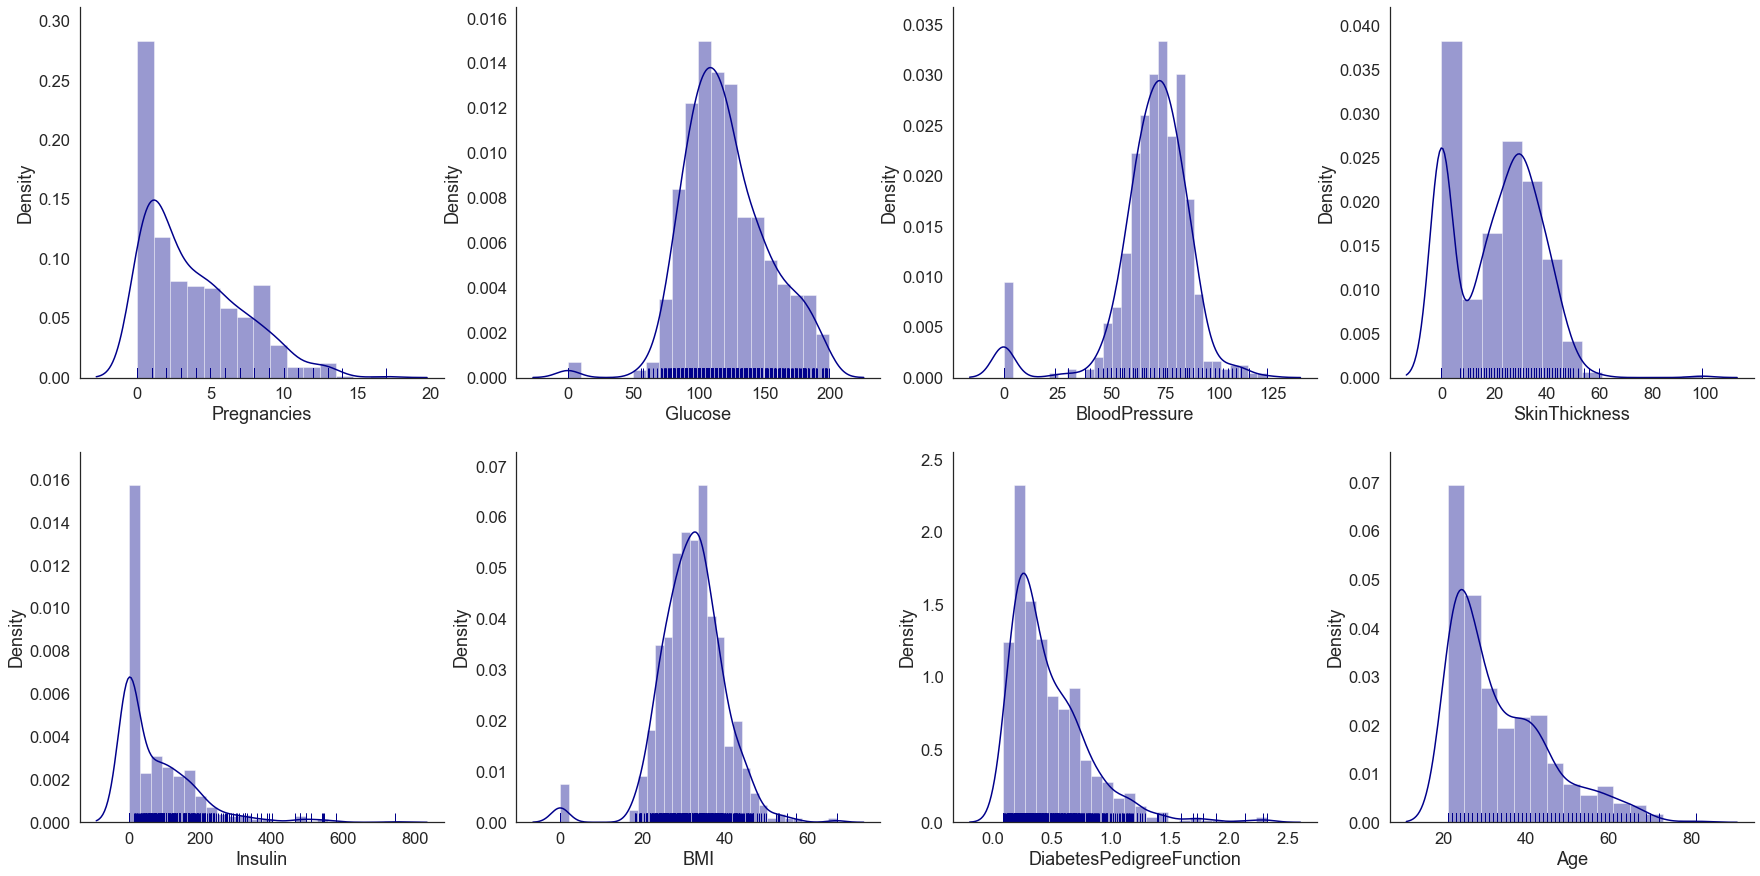

In [12]:
rcParams['figure.figsize'] =30,15
sns.set(font_scale = 1.5)
sns.set_style("white")
plt.subplots_adjust(hspace=1)
fig, axes = plt.subplots(2, 4)
for i in range(4):
    sns.distplot(X_train[num_cols[i]],ax = axes[0,i],rug=True,color='darkblue')
    #sns.boxplot(diabetes_df[num_cols[i]],ax = axes[1,i],color='red')  
    #stats.probplot(diabetes_df[num_cols[i]],plot = axes[2,i])
    sns.despine()
for i in range(4,8):
    sns.distplot(X_train[num_cols[i]],ax = axes[1,i-4],rug=True,color='darkblue')
    #sns.boxplot(diabetes_df[num_cols[i]],ax = axes[4,i-4],color='red')  
    #stats.probplot(diabetes_df[num_cols[i]],plot = axes[5,i-4])
    sns.despine()
    #5B84B1FF

- **Pregnancies**, **Insulin**, **DiabetesPedigreeFunction**, **Skin Thickness** and **Age** have **positively or rightly** skewed data distribution.
- Data distributions of **Glucose**, **BloodPressure** & **BMI** are near a **normal distribution** 

--------------------------------------------
## Preprocessing

### Pregnancies

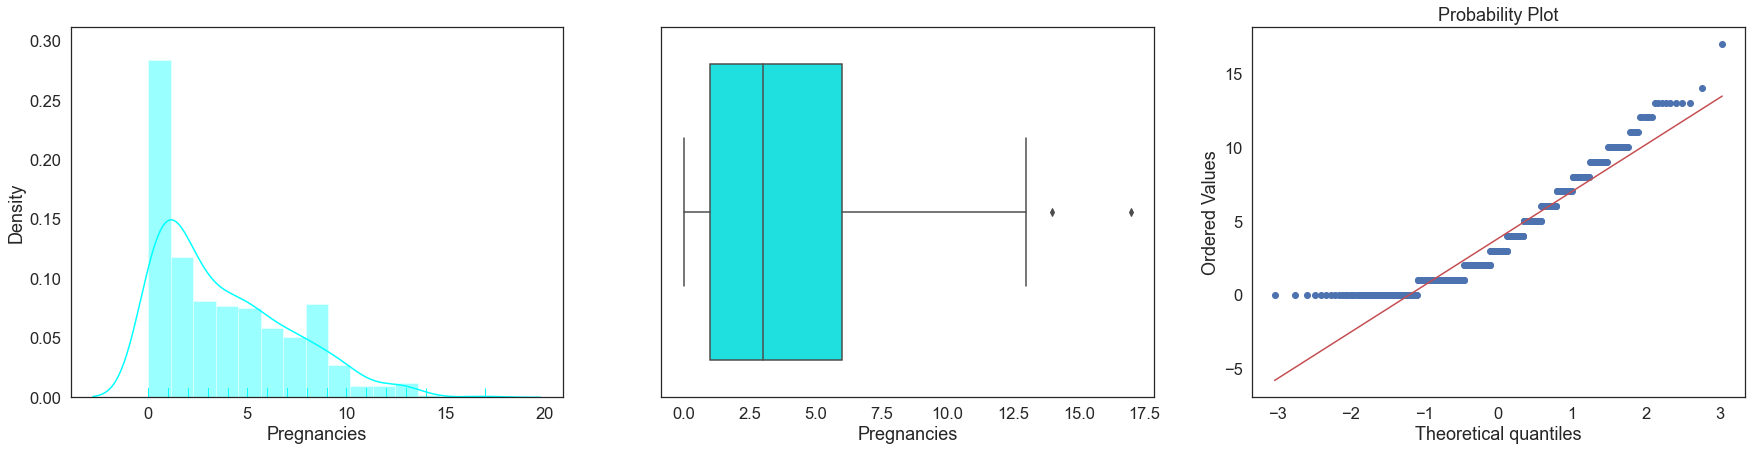

In [13]:
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[0]],ax = plt.subplot(2,3,1)  ,rug=True,color='Aqua')
    sns.boxplot(X_train[num_cols[0]],ax = plt.subplot(2,3,2)  ,color='Aqua')  
    stats.probplot(X_train[num_cols[0]],plot = plt.subplot(2,3,3))  

In [14]:
print(X_train.shape)
print(y_train.shape)

(576, 9)
(576,)


It is normal to have  **zeroes values** and also there are **outliers**.

In [15]:
#Treating Outlier and then verifying it
X_train = out_remove('Pregnancies',X_train,'both',1.5)
#---------------------
X_test = out_remove('Pregnancies',X_test,'both',1.5)
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
751,1,121,78,39,74,39.0,0.261,28,0
358,12,88,74,40,54,35.3,0.378,48,0
718,1,108,60,46,178,35.5,0.415,24,0
536,0,105,90,0,0,29.6,0.197,46,0
651,1,117,60,23,106,33.8,0.466,27,0
...,...,...,...,...,...,...,...,...,...
676,9,156,86,0,0,24.8,0.230,53,1
113,4,76,62,0,0,34.0,0.391,25,0
556,1,97,70,40,0,38.1,0.218,30,0
152,9,156,86,28,155,34.3,1.189,42,1


### Glucose

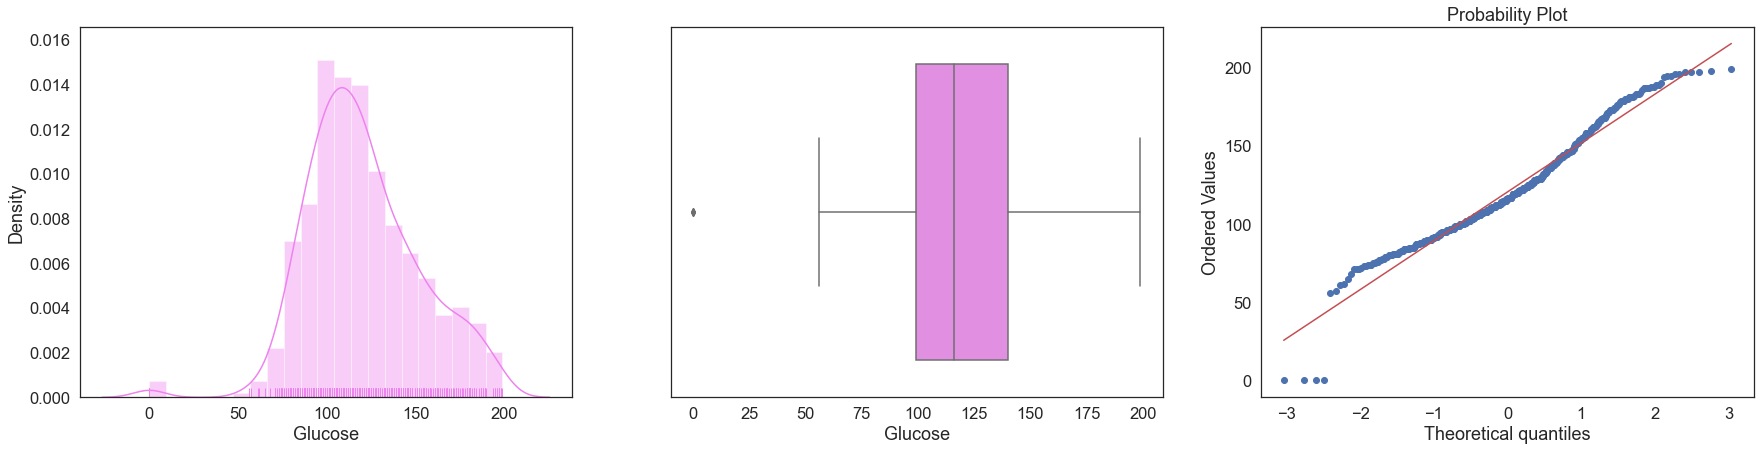

In [16]:
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[1]],ax = plt.subplot(2,3,1)  ,rug=True,color='Violet')
    sns.boxplot(X_train[num_cols[1]],ax = plt.subplot(2,3,2)  ,color='Violet')  
    stats.probplot(X_train[num_cols[1]],plot = plt.subplot(2,3,3)) 

 There is **few outliers** and also distribution is **normal** , So we decided to fill **zeroes** with **mean** value.

In [17]:
X_train['Glucose'] = X_train['Glucose'].replace(0,X_train['Glucose'].mean())
#------------------
X_test['Glucose'] = X_test['Glucose'].replace(0,X_test['Glucose'].mean())

In [18]:
X_train = out_remove('Glucose',X_train,'both',1.5)
#-----------------
X_test = out_remove('Glucose',X_test,'both',1.5)


### BloodPressure

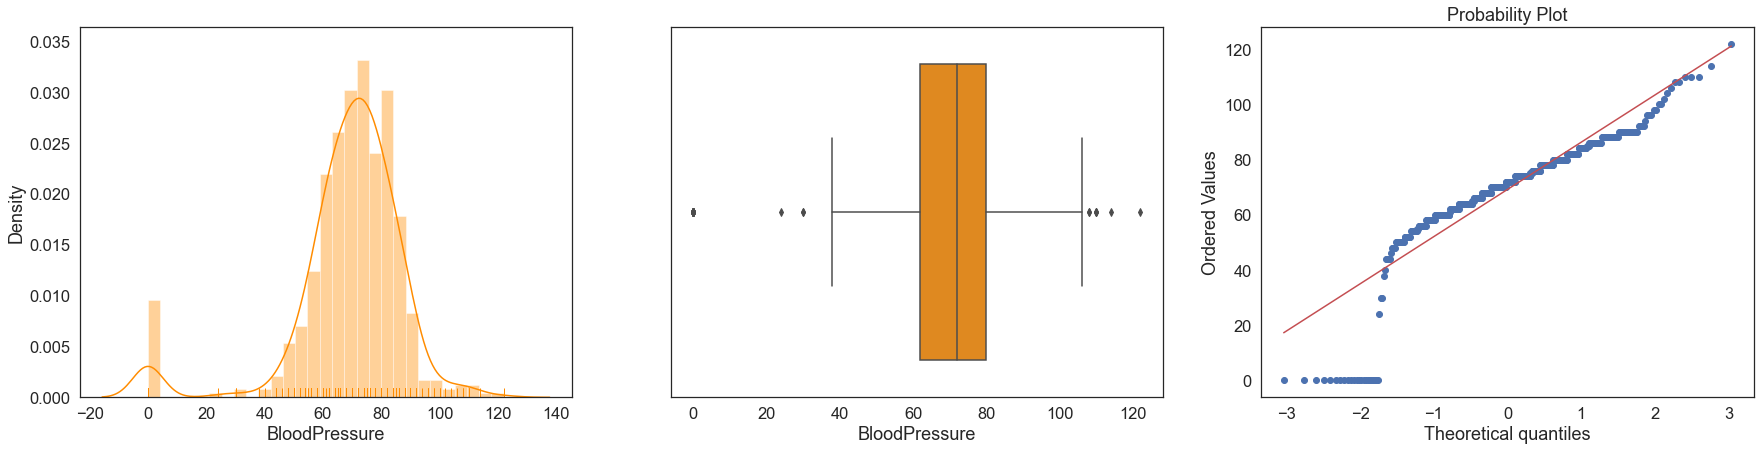

In [19]:
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[2]],ax = plt.subplot(2,3,1)  ,rug=True,color='DarkOrange')
    sns.boxplot(X_train[num_cols[2]],ax = plt.subplot(2,3,2)  ,color='DarkOrange')  
    stats.probplot(X_train[num_cols[2]],plot = plt.subplot(2,3,3)) 

It looks like there are few Outliers at both higher end and lower end. **But at higher end maximum Blood Pressure is 122, So it is considerable.** Now at lower end BP near 25 is not making sense. so we decided to treplace zeroes with median and remove the outliers.

In [20]:
X_train['BloodPressure'] = X_train['BloodPressure'].replace(0,X_train['BloodPressure'].median())
#------------
X_test['BloodPressure'] = X_test['BloodPressure'].replace(0,X_test['BloodPressure'].median())

In [21]:
X_train = out_remove('BloodPressure',X_train,'lower',1.5)
#------------
X_test = out_remove('BloodPressure',X_test,'lower',1.5)

### SkinThickness

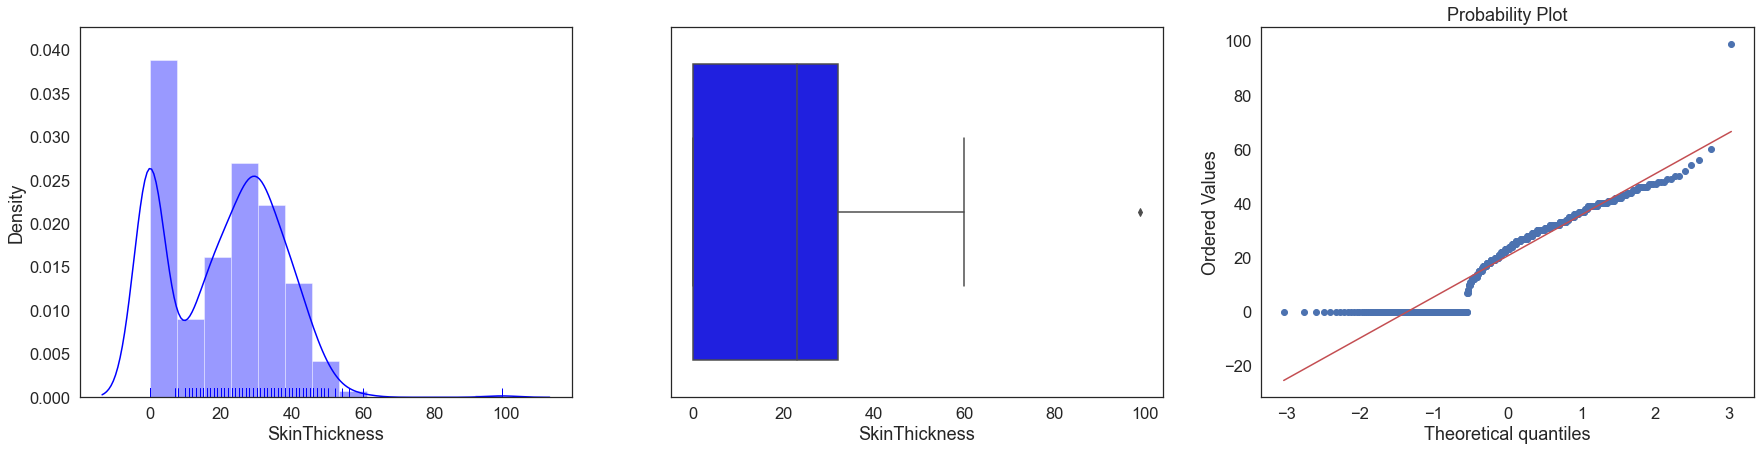

In [22]:
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[3]],ax = plt.subplot(2,3,1)  ,rug=True,color='blue')
    sns.boxplot(X_train[num_cols[3]],ax = plt.subplot(2,3,2)  ,color='blue')  
    stats.probplot(X_train[num_cols[3]],plot = plt.subplot(2,3,3)) 

In [23]:
X_train['SkinThickness'] = X_train['SkinThickness'].replace(0,X_train['SkinThickness'].mean())
#-----------
X_test['SkinThickness'] = X_test['SkinThickness'].replace(0,X_test['SkinThickness'].mean())

In [24]:
X_train = out_remove('SkinThickness',X_train,'both',1.5)
#------------
X_test = out_remove('SkinThickness',X_test,'both',1.5)

### Insulin

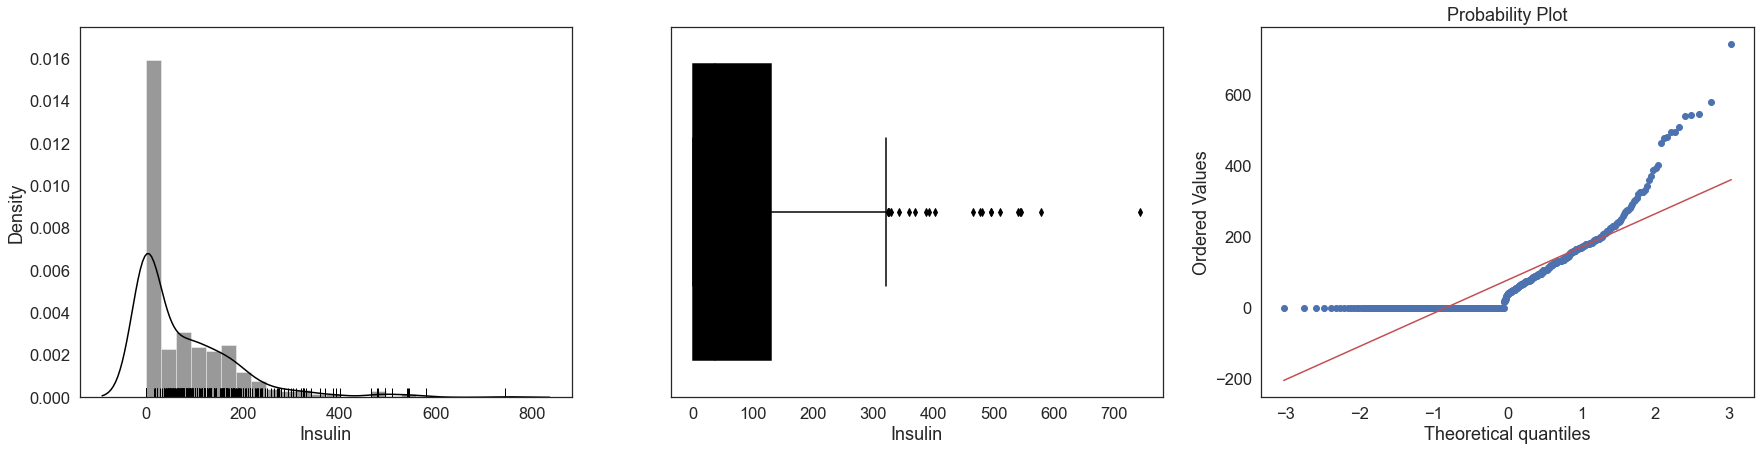

In [25]:
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[4]],ax = plt.subplot(2,3,1)  ,rug=True,color='black')
    sns.boxplot(X_train[num_cols[4]],ax = plt.subplot(2,3,2)  ,color='black')  
    stats.probplot(X_train[num_cols[4]],plot = plt.subplot(2,3,3)) 

**We can see there are many outliers. So we decided to fill Zeroes with Median of Insulin and also treat Outliers after removing zero.**

In [26]:
X_train['Insulin'] = X_train['Insulin'].replace(0,X_train['Insulin'].median())
#-----------
X_test['Insulin'] = X_test['Insulin'].replace(0,X_test['Insulin'].median())

In [27]:
X_train = out_remove('Insulin',X_train,'both',1.5)
#------------
X_test = out_remove('Insulin',X_test,'both',1.5)

### BMI

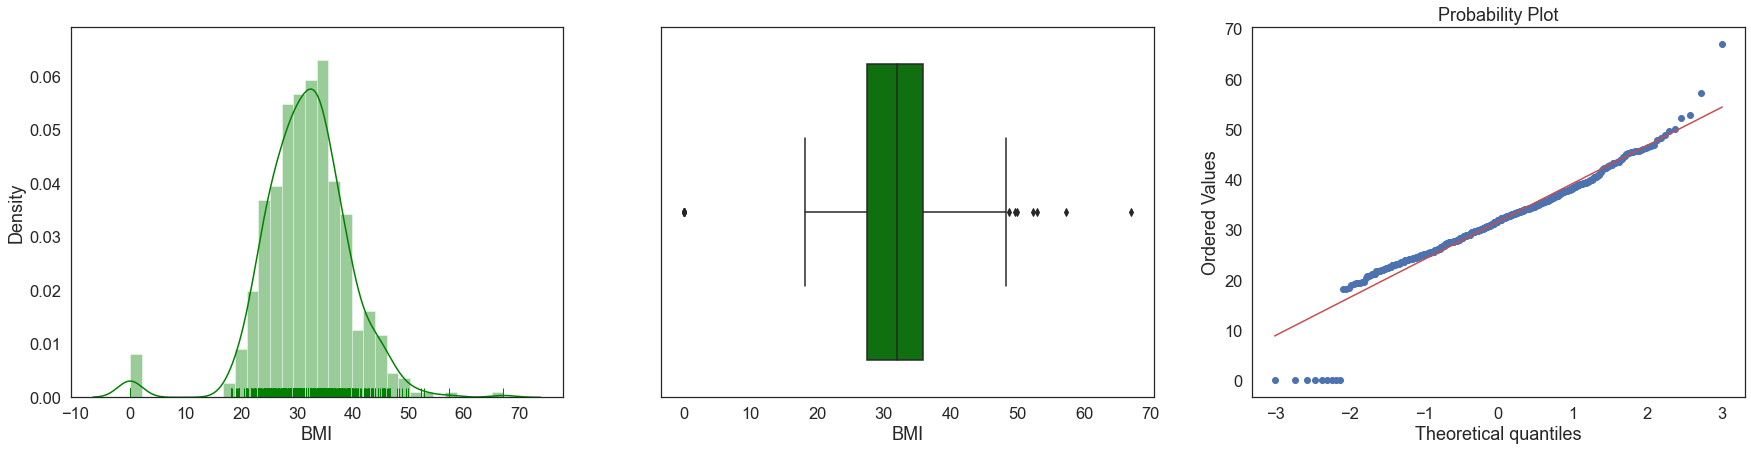

In [28]:
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[5]],ax = plt.subplot(2,3,1)  ,rug=True,color='green')
    sns.boxplot(X_train[num_cols[5]],ax = plt.subplot(2,3,2)  ,color='green')  
    stats.probplot(X_train[num_cols[5]],plot = plt.subplot(2,3,3)) 

In [29]:
X_train['BMI'] = X_train['BMI'].replace(0,X_train['BMI'].mean())
#----------
X_test['BMI'] = X_test['BMI'].replace(0,X_test['BMI'].mean())

### DPF

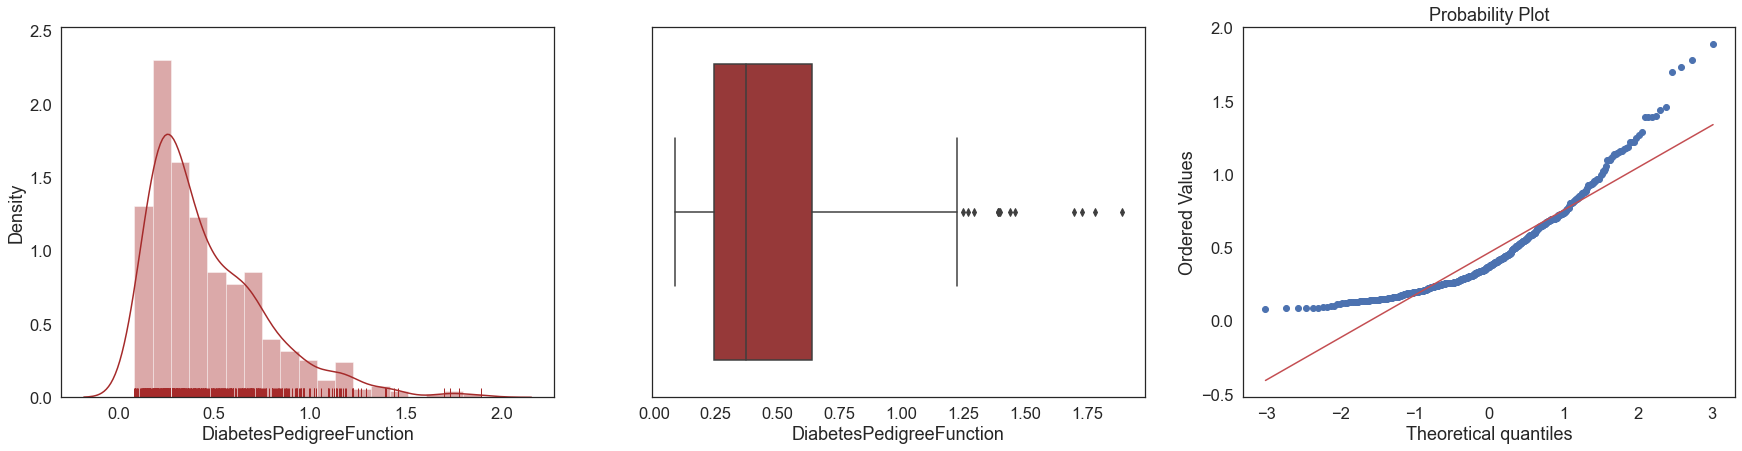

In [30]:
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[6]],ax = plt.subplot(2,3,1)  ,rug=True,color='brown')
    sns.boxplot(X_train[num_cols[6]],ax = plt.subplot(2,3,2)  ,color='brown')  
    stats.probplot(X_train[num_cols[6]],plot = plt.subplot(2,3,3)) 

In [31]:
X_train = out_remove('DiabetesPedigreeFunction',X_train,'both',1.5)
#------------
X_test = out_remove('DiabetesPedigreeFunction',X_test,'both',1.5)

### Age

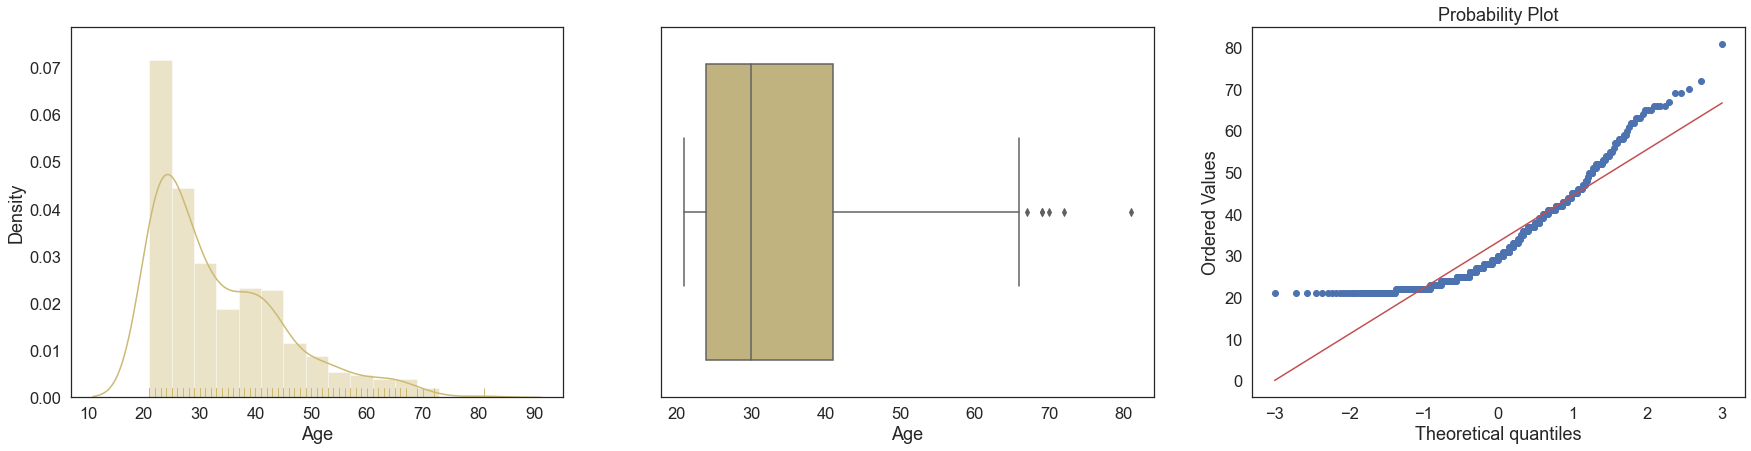

In [32]:
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[7]],ax = plt.subplot(2,3,1)  ,rug=True,color='y')
    sns.boxplot(X_train[num_cols[7]],ax = plt.subplot(2,3,2)  ,color='y')  
    stats.probplot(X_train[num_cols[7]],plot = plt.subplot(2,3,3)) 

there are some **outliers** but they are meanigful that age can be **60,70,80**

### Data after Cleaning

<Figure size 2160x1080 with 0 Axes>

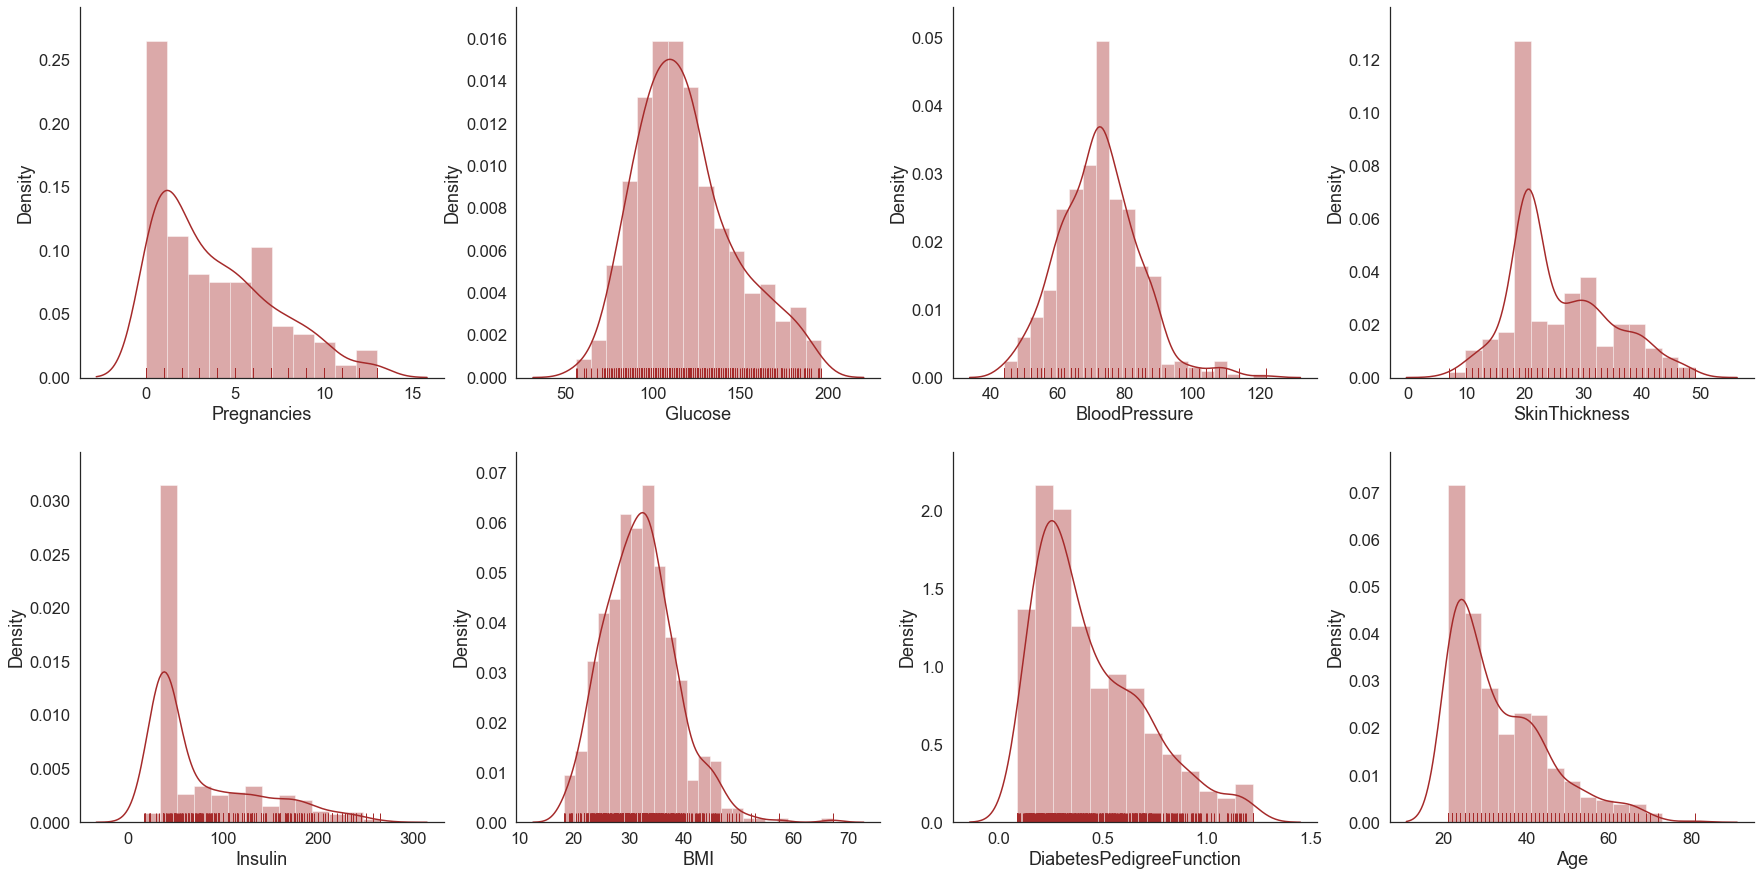

In [33]:
rcParams['figure.figsize'] =30,15
sns.set(font_scale = 1.5)
sns.set_style("white")
plt.subplots_adjust(hspace=1)
fig, axes = plt.subplots(2, 4)
for i in range(4):
    sns.distplot(X_train[num_cols[i]],ax = axes[0,i],rug=True,color='brown')
    #sns.boxplot(diabetes_df[num_cols[i]],ax = axes[1,i],color='red')  
    #stats.probplot(diabetes_df[num_cols[i]],plot = axes[2,i])
    sns.despine()
for i in range(4,8):
    sns.distplot(X_train[num_cols[i]],ax = axes[1,i-4],rug=True,color='brown')
    #sns.boxplot(diabetes_df[num_cols[i]],ax = axes[4,i-4],color='red')  
    #stats.probplot(diabetes_df[num_cols[i]],plot = axes[5,i-4])
    sns.despine()

----
### Correlation Matrix :

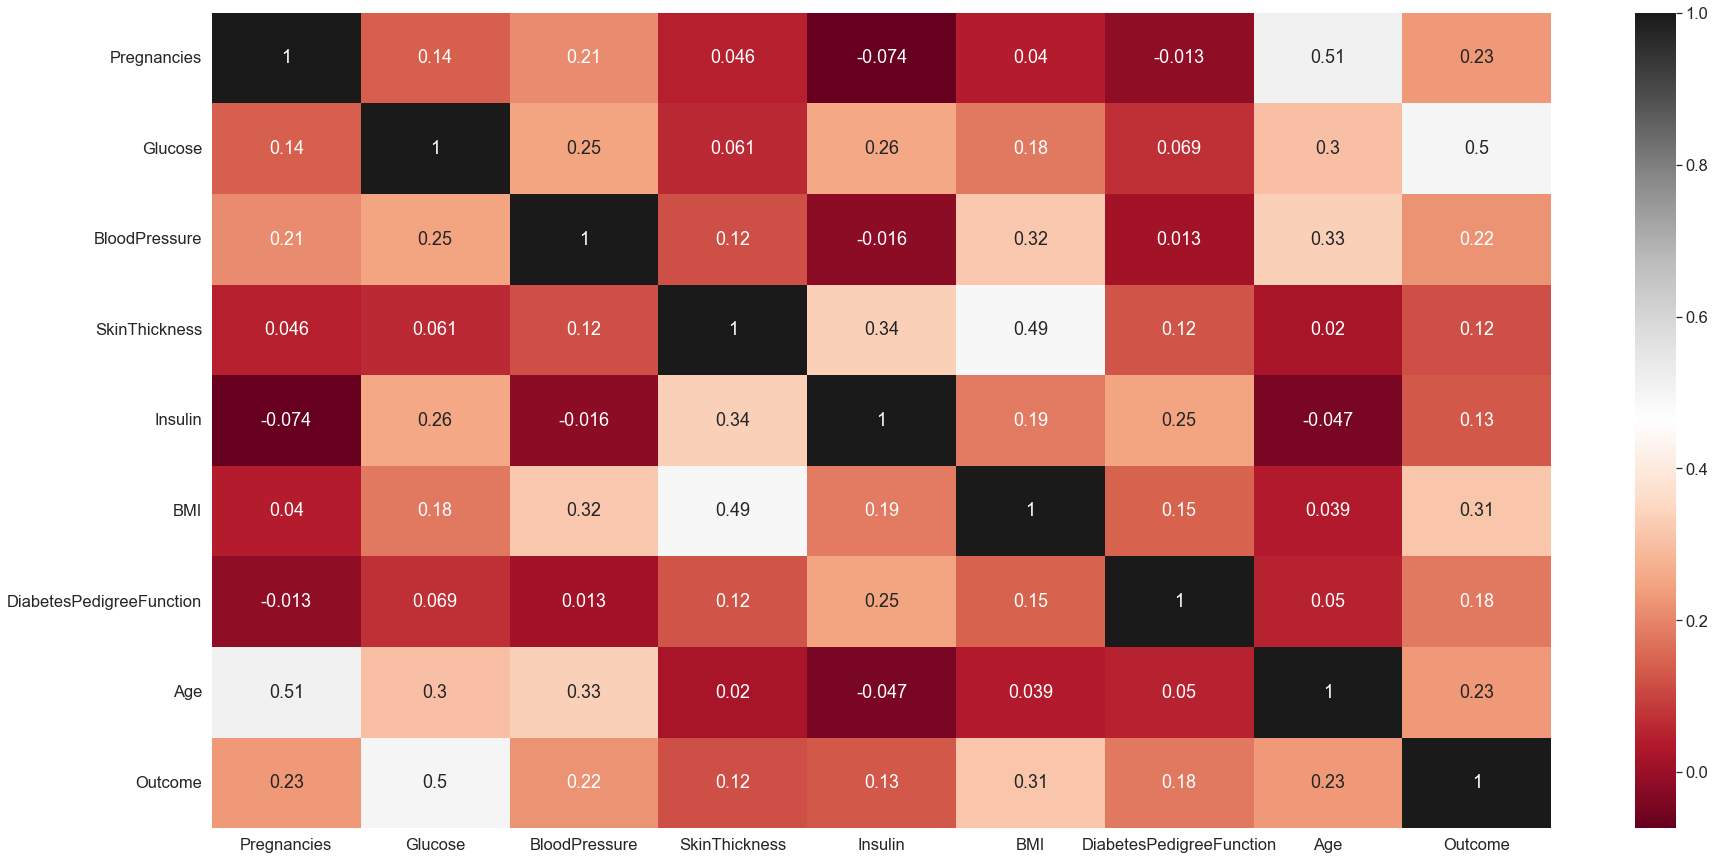

In [34]:
#plt.figure(figsize = (35,15))
sns.heatmap(X_train.corr(),cmap = 'RdGy',annot = True,cbar=True);

<span style="color:red"> **Observation:**
* The correlation between Outcome and Glucose is high.
* High correlation coefficient with Pregnancies and Age. 
* High correlation coefficient with SkinThickness and BMI.

**- Now, let's visualize the correlation between BMI & SkinThickness**

(4.0, 60.0)

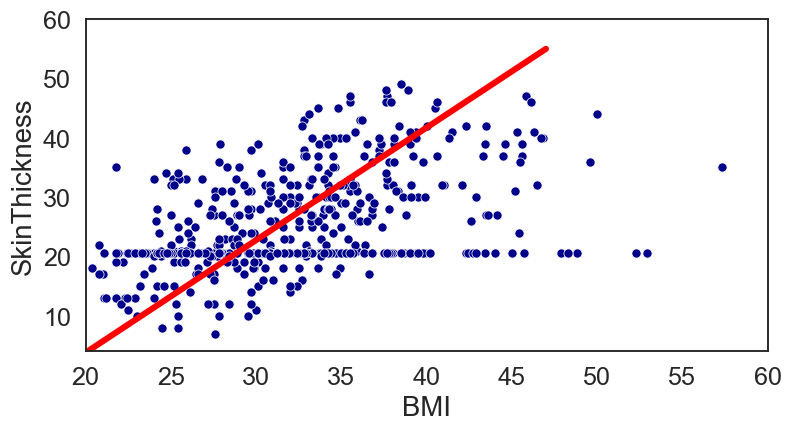

In [35]:
plt.figure(figsize=(8,4),dpi=110)
sns.scatterplot(data=X_train, x='BMI', y='SkinThickness', color='darkblue');
plt.plot([18, 47], [0, 55], 'red', linewidth=4)
plt.xlim(20, 60)
plt.ylim(4, 60)


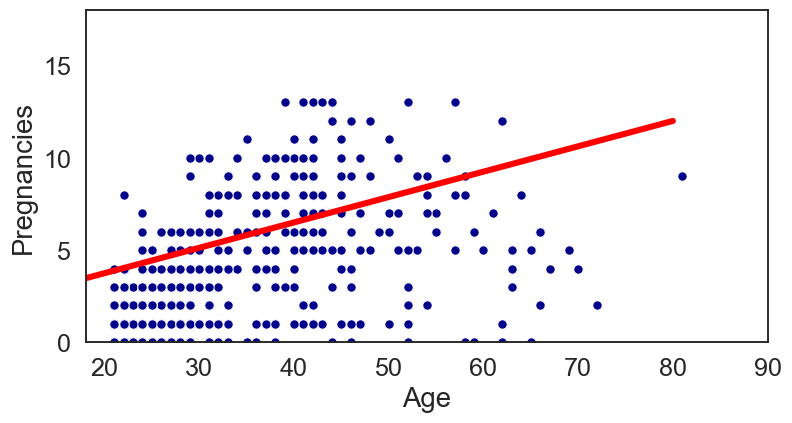

In [36]:
plt.figure(figsize=(8,4),dpi=110)
sns.scatterplot(data=X_train, x='Age', y='Pregnancies',color='darkblue');
plt.plot([0, 80], [1, 12], 'red', linewidth=4)
plt.ylim(0, 18)
plt.xlim(18, 90)


plt.show()

----
### Feature Importance

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

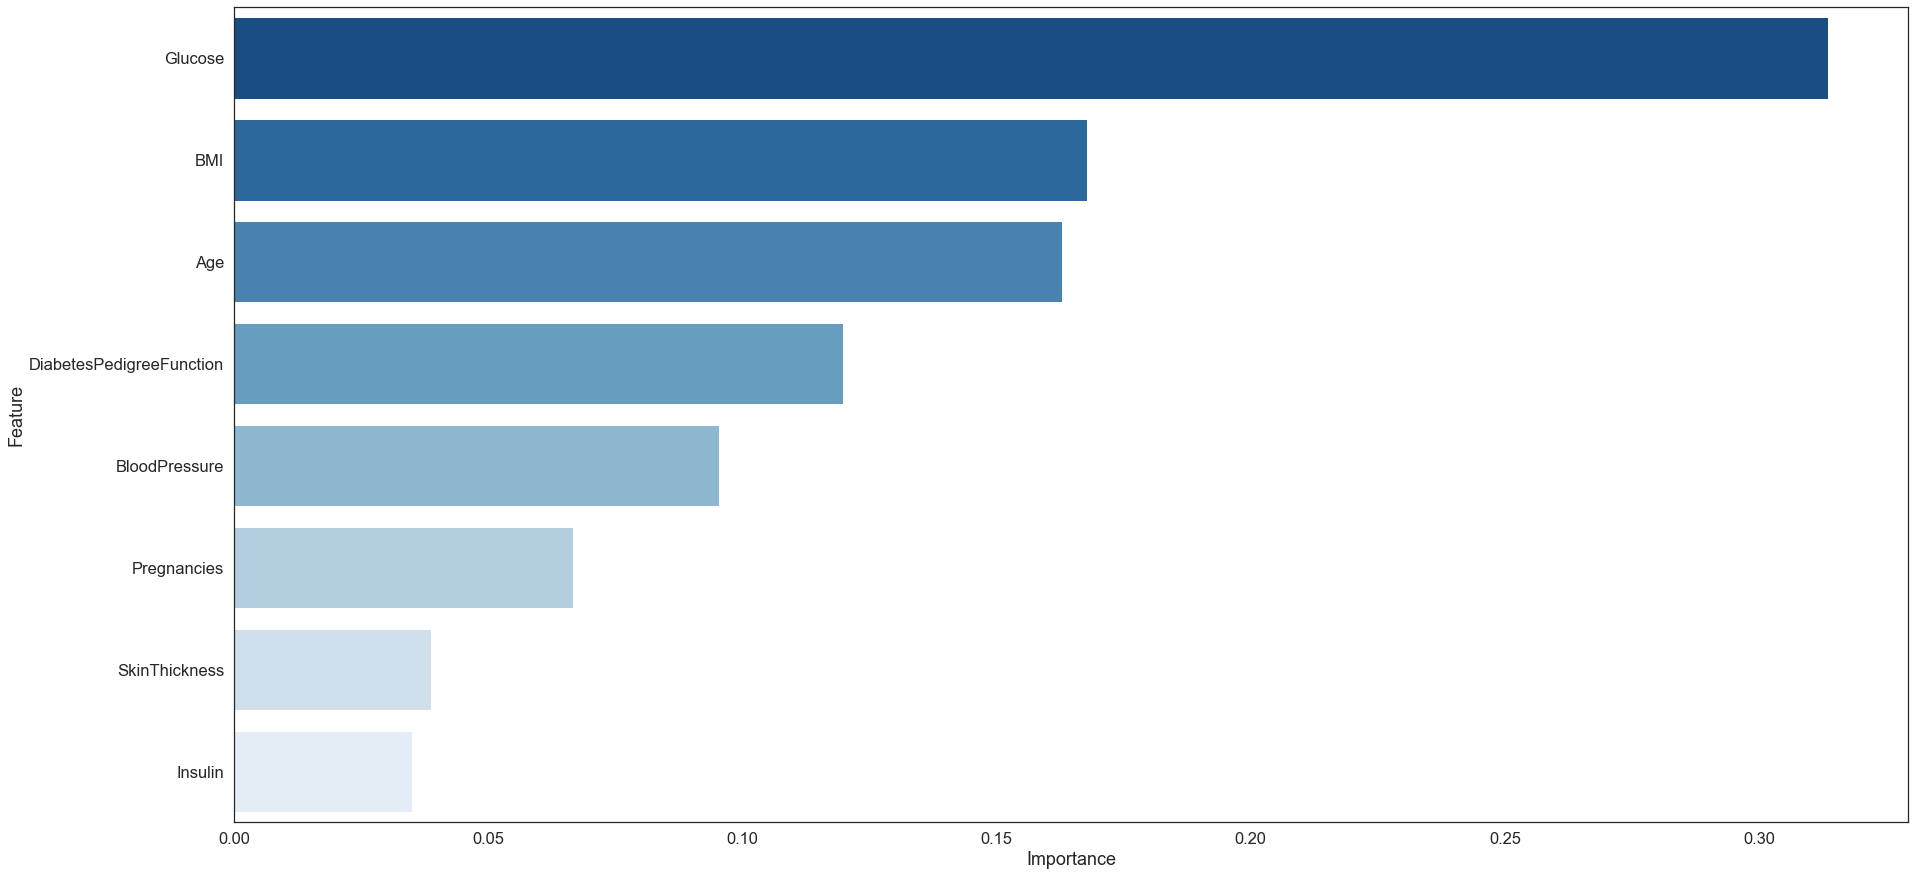

In [37]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree model

model = DecisionTreeClassifier()
z_copy = X_train.copy()
y = z_copy.iloc[:,-1]
X = z_copy.iloc[:,:-1]
model.fit(X, y)
importances = model.feature_importances_
#print(model.feature_importances_)
indices = np.argsort(importances)[::-1]
df = pd.DataFrame({'Feature': X.columns[indices], 'Importance': importances[indices]})
sns.barplot(x='Importance', y='Feature', palette="Blues_r",data=df )


<span style="color:red"> **Observation:**
* Glucose, BMI and Age have high Importance.
    
* Since Insulin has 50% of data **Nan** values and has low Importance so, we decided to **remove** it.
* Since SkinThickness has correlation with **BMI**  and has low Importance so, we decided to **remove** it.

In [38]:
X_train.drop(['Insulin', 'SkinThickness'], axis=1, inplace=True)
X_test.drop(['Insulin', 'SkinThickness'], axis=1, inplace=True)


-----
### Glucose

<AxesSubplot:xlabel='Glucose', ylabel='DiabetesPedigreeFunction'>

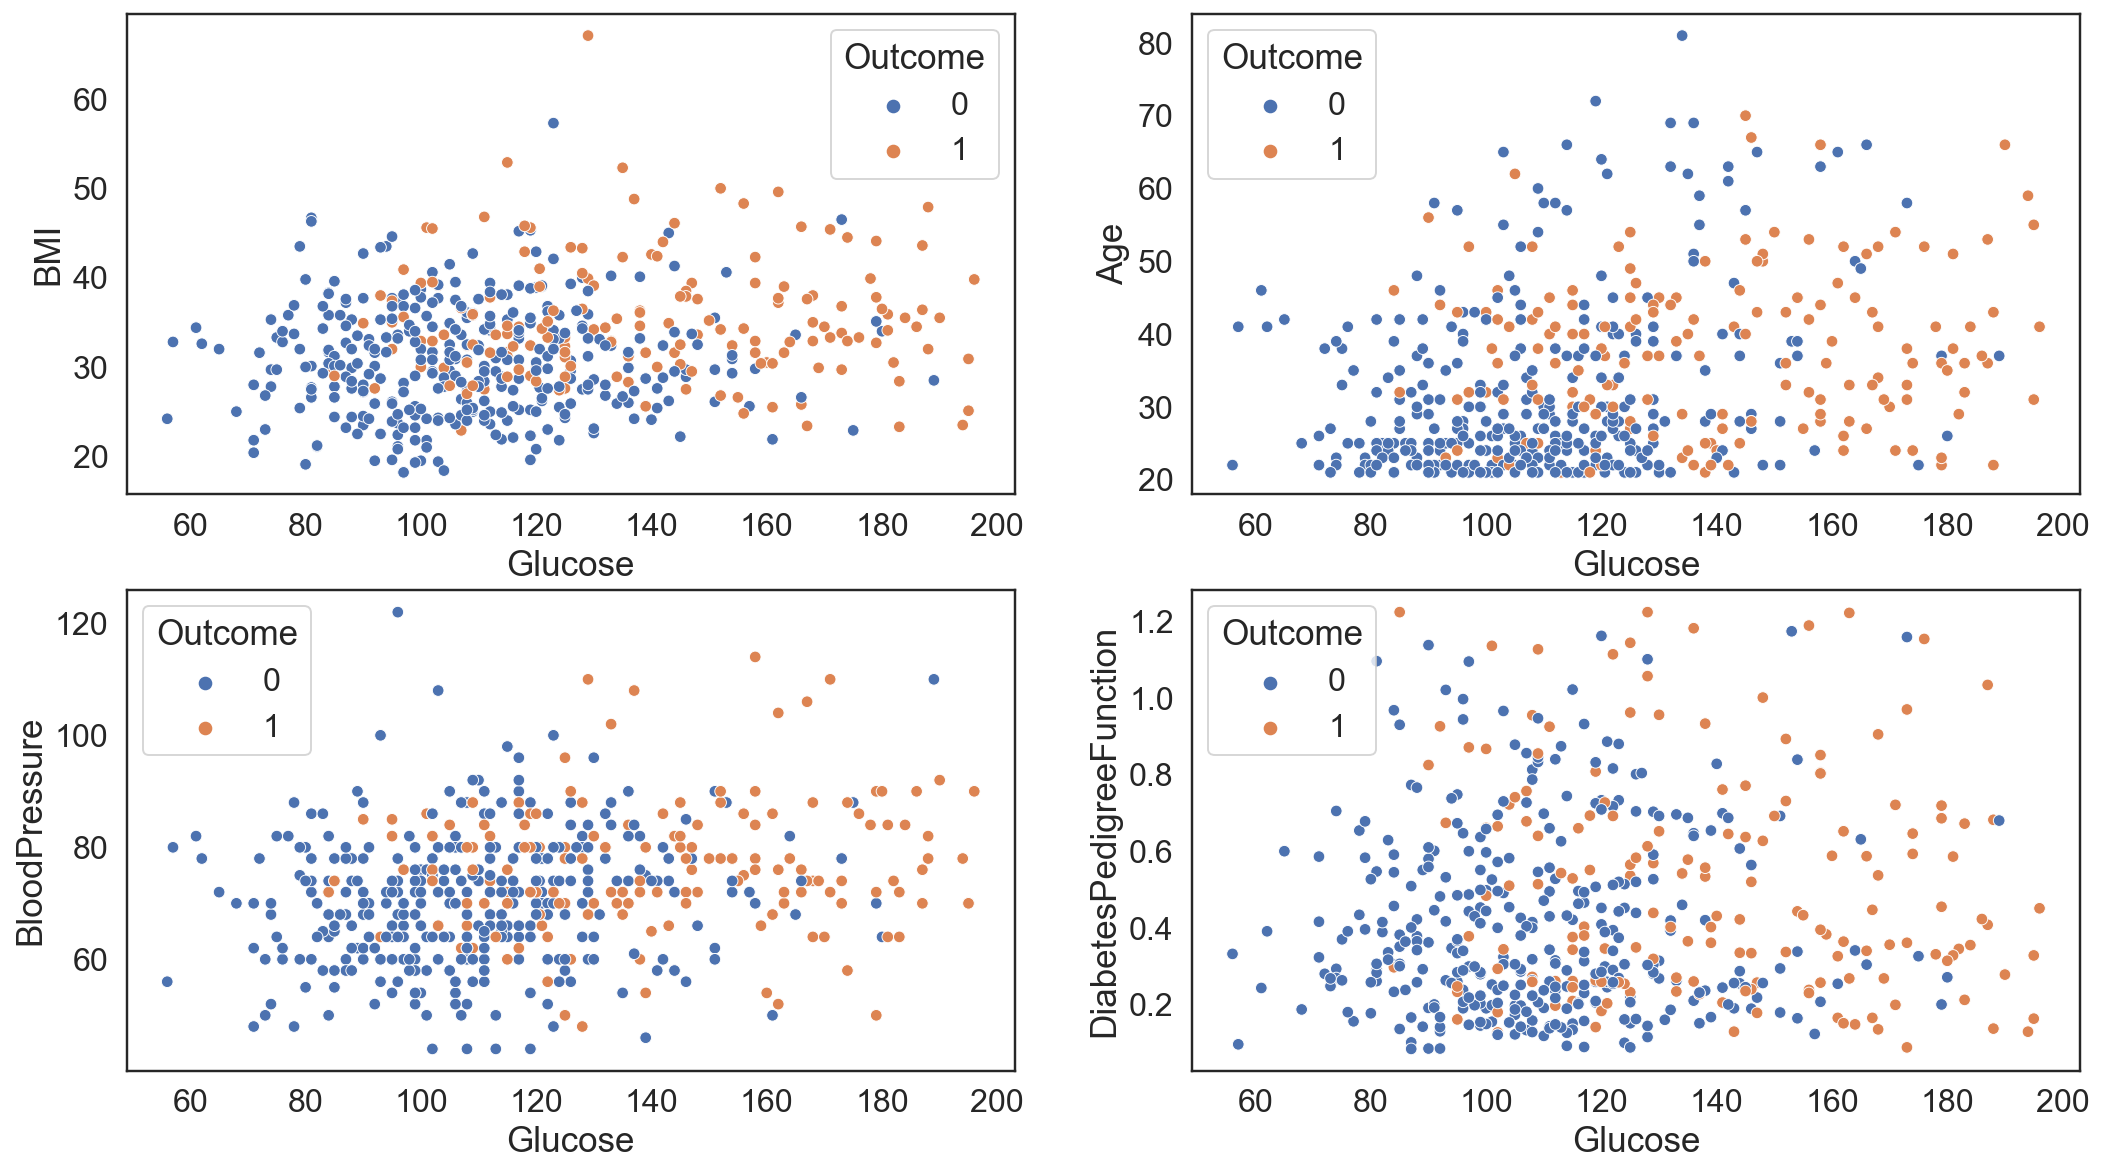

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(18,10 ),dpi=140)
sns.scatterplot(data=X_train, x='Glucose', y='BMI',  hue='Outcome', ax=ax[0][0])
sns.scatterplot(data=X_train, x='Glucose', y='Age', hue='Outcome', ax=ax[0][1])
sns.scatterplot(data=X_train, x='Glucose', y='BloodPressure',  hue='Outcome', ax=ax[1][0])
sns.scatterplot(data=X_train, x='Glucose', y='DiabetesPedigreeFunction',  hue='Outcome', ax=ax[1][1])


---
# Scaling & Modeling

In [40]:
y_train = X_train.iloc[:,-1]
X_train = X_train.iloc[:,:-1]
y_test = X_test.iloc[:,-1]
X_test = X_test.iloc[:,:-1]

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE



-----
### Data Balancing using SMOTE :

In [42]:
SMT=SMOTE()

**StandardScaler**

In [43]:
scaler= StandardScaler()

**QuantileTransformer**

In [44]:
QUAT = QuantileTransformer(random_state=5, output_distribution='normal')


----
### KNN Model

In [59]:
KNN=KNeighborsClassifier(n_neighbors=3)
lis = list(range(1,300))
Param = {'KNN__n_neighbors': lis}
p = Pipeline([('SMT', SMT),('QUAT',QUAT),('KNN', KNN)])
Grid=GridSearchCV(p,param_grid=Param,cv=5,scoring='precision')
Grid.fit(X_train,y_train)
print(Grid.best_score_)
print(Grid.best_params_)


0.6183333333333334
{'KNN__n_neighbors': 4}


In [60]:
Final = KNeighborsClassifier(n_neighbors=4)

Model = Pipeline([('SMT', SMT),('QUAT',QUAT), ('Final', Final)])
Model.fit(X_train, y_train)
Pred = Model.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       113
           1       0.60      0.61      0.60        51

    accuracy                           0.75       164
   macro avg       0.71      0.71      0.71       164
weighted avg       0.75      0.75      0.75       164



Text(0, 0.5, 'True positive rate')

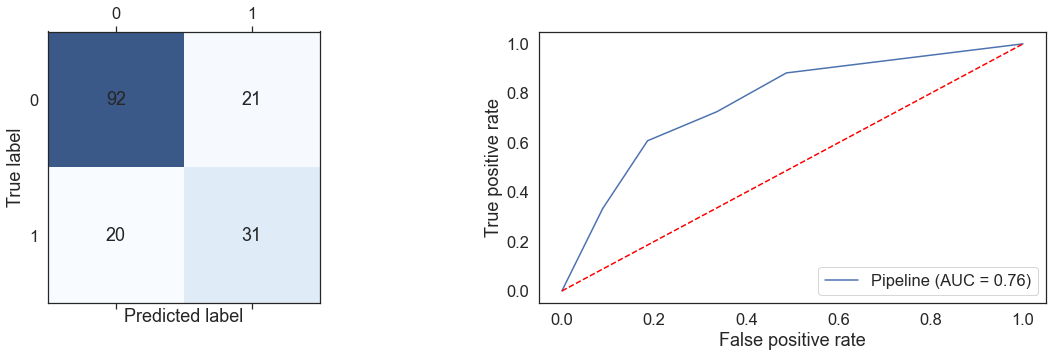

In [61]:
confusion = confusion_matrix(y_test, Pred)
print(classification_report(y_test, Pred))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.matshow(confusion, cmap='Blues',alpha=0.8)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax1.text(x=j, y=i, s=confusion[i, j], va='center', ha='center')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

plot_roc_curve(Model, X_test, y_test, ax=ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', color='red')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')

#roc_auc_score(y_test, Pred)
fpr_1, tpr_1, thresholds_1=roc_curve(y_test, Pred)
_result=pd.concat([pd.Series(thresholds_1),pd.Series(accuracy_ls)],axis=1)
_result.columns=['threshold','accuracy score']


# Create an XGBoost model
model = XGBClassifier()

# Define the hyperparameter grid for the XGBoost model
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.1, 0.5, 1.0],
    'xgb__n_estimators': [10, 50, 100],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],

}

# Create the pipeline with XGBoost as the estimator
pipeline = Pipeline([('xgb', model)])

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score



print(grid_search.best_params_)
print(grid_search.best_score_)

Final = XGBClassifier(max_depth=7,learning_rate= 0.1,n_estimators= 100,gamma=1.5,min_child_weight= 1)
operations = [('Final', Final)]
Pipe = Pipeline(operations)

#Fit The PipeLine on the entire data which we did the GridSearchCV (training/validation) on.
Pipe.fit(X_train, y_train)
Final_pred = Pipe.predict(X_test)
#print(classification_report(y_test, Final_pred))
#plt.figure(figsize = (5,5))
#plot_roc_curve(Pipe, X_test, y_test)
#plot_confusion_matrix(Pipe, X_test, y_test)


confusion = confusion_matrix(y_test, Final_pred)
print(classification_report(y_test, Final_pred))

# Set up the figure and the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot the confusion matrix on the first subplot
ax1.matshow(confusion, cmap='Blues',alpha=0.8)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax1.text(x=j, y=i, s=confusion[i, j], va='center', ha='center')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

# Plot the ROC curve on the second subplot
plot_roc_curve(Pipe, X_test, y_test, ax=ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', color='red')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
